In this example we will train emotion classification model based on The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset ([reference](https://zenodo.org/record/1188976))

## Downloading and installing the **voice_characterizer** library

In [41]:
%%capture --no-stderr
!wget "https://drive.google.com/uc?id=1vYR-S4Vk7MAYdIZS0sa8mN9CCGbN8AY-" -O "/content/vanpy-0.71.9-py3-none-any.whl"
!pip install "/content/vanpy-0.71.9-py3-none-any.whl"

## Installing prerequisites
We will convert audio format in preprocessing, there is a need to install the **ffmpeg** utility.

In [2]:
#@title <font size="4"><i>Installing ffmpeg</font><br/><font size="3">Taken from <a href="https://colab.research.google.com/github/yunooooo/FFmpeg-for-Google-Drive/blob/master/FFmpeg.ipynb">here</a></font> { vertical-output: true }
from IPython.display import clear_output
import os, urllib.request
HOME = os.path.expanduser("~")
pathDoneCMD = f'{HOME}/doneCMD.sh'
if not os.path.exists(f"{HOME}/.ipython/ttmg.py"):
    hCode = "https://raw.githubusercontent.com/yunooooo/gcct/master/res/ttmg.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ttmg.py")

from ttmg import (
    loadingAn,
    textAn,
)

loadingAn(name="lds")
textAn("Installing Dependencies...", ty='twg')
os.system('pip install git+git://github.com/AWConant/jikanpy.git')
os.system('add-apt-repository -y ppa:jonathonf/ffmpeg-4')
os.system('apt-get update')
os.system('apt install mediainfo')
os.system('apt-get install ffmpeg')
clear_output()
print('Installation finished.')

Installation finished.


## Downloading the dataset


In [33]:
# %%capture --no-stderr
dataset_dir = "dataset"
!mkdir $dataset_dir
# download the dataset
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1 -O $dataset_dir"/Audio_Speech_Actors_01-24.zip"
# unzip and remove the archive
!unzip -qq $dataset_dir"/Audio_Speech_Actors_01-24.zip" -d $dataset_dir
!rm $dataset_dir"/Audio_Speech_Actors_01-24.zip"
# move the files from subfolders to "./dataset"
!find $dataset_dir -type f -mindepth 2 -exec mv {} ./dataset \;
# remove redundant directories
!find $dataset_dir -depth -mindepth 1 -type d -empty -exec rmdir {} \;

# Create a mapping DataFrame

In [34]:
import pandas as pd
# Filename identifiers:
#   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
#   Vocal channel (01 = speech, 02 = song).
#   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
#   Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
#   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
#   Repetition (01 = 1st repetition, 02 = 2nd repetition).
#   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

file_emotion = []
file_path = []
ravdess_directory_list = os.listdir(dataset_dir)
for f in ravdess_directory_list:
  parts = f.split('.')[0].split('-')
  file_emotion.append(int(parts[2]))
  file_path.append(dataset_dir + '/' + f)
        
ravdess_df = pd.DataFrame(list(zip(file_emotion, file_path)), columns=['emotion', 'path'])

# mapping to textual labels
ravdess_df['emotion'] = ravdess_df['emotion'].replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'})
ravdess_df.head()

,emotion,path
0,disgust,dataset/03-01-07-02-01-02-10.wav
1,fearful,dataset/03-01-06-02-02-02-16.wav
2,surprised,dataset/03-01-08-02-02-02-22.wav
3,happy,dataset/03-01-03-02-01-01-17.wav
4,angry,dataset/03-01-05-02-01-01-02.wav


## Running the voice characterization pipeline

In [57]:
%%capture --no-stderr
# get the pipline configuration file
!wget "https://drive.google.com/uc?id=1rP_vr3wQxjdu-1sAXY728UvvFGccnI8D" -O "/content/pipeline.yaml"
# change the input_dir in the configuration
!sed -E -i "s/input_dir: '[0-9a-zA-Z_]*'/input_dir: \'dataset\'/g" "/content/pipeline.yaml"

In [58]:
import yaml
import logging
logging.basicConfig(level=logging.INFO)  # You can configure the log-level to
                                         # reach the desired verbosity
from vanpy.core.ClassificationPipline import ClassificationPipeline
from vanpy.core.FeatureExtractionPipline import FeatureExtractionPipeline
from vanpy.core.PreprocessPipline import PreprocessPipeline
from vanpy.core.CombinedPipeline import CombinedPipeline


# loading the configuration of the pipeline and its components from pipline.yaml
with open('pipeline.yaml', 'r') as f:
  config = yaml.load(f, Loader=yaml.FullLoader)

# declaring the preprocessing pipeline
preprocessing_pipeline = PreprocessPipeline(
  ['file_mapper', 'wav_converter'], config=config)
# declaring the feature extraction pipeline
# this is required for the training set generation or whether one of the models
# is expecting the features as input (e.g. 'common_voices_gender')
feature_extraction_pipeline = FeatureExtractionPipeline(
  ['pyannote_embedding'], config=config)
# # declaring the classification pipeline
# # some of the classifiers use the features columns and others preprocessed files
# speaker_clf_pipeline = ClassificationPipeline(
#   ['common_voices_gender', 'common_voices_age', 'speech_brain_iemocap_emotion'], 
#   config=config)

# combining all of the pipelines together
pipline = CombinedPipeline(
  [preprocessing_pipeline, feature_extraction_pipeline],
  config=config)
# executing pipeline
processed_payload = pipline.process()

Downloading:   0%|          | 0.00/96.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

In [59]:
payload_df = processed_payload.get_features_df()
payload_df

,wav_converter_processed_path,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,perf_pyannote_embedding_get_features
0,convert_preprocessed/03-01-07-02-01-02-10.wav,3.757032,-67.166191,47.828449,-29.073359,12.684258,11.216756,-37.408550,26.126684,24.535559,...,64.420334,42.639084,-28.356934,-13.075211,16.247488,-16.521589,62.712841,36.853222,2.362888,0.306717
1,convert_preprocessed/03-01-06-02-02-02-16.wav,38.697029,63.182175,18.560995,38.191566,45.961411,-42.785561,-66.803818,1.553951,37.697731,...,19.032248,-3.494895,23.764862,6.152300,6.235340,-42.942944,55.854130,50.632065,-62.389709,0.069279
2,convert_preprocessed/03-01-08-02-02-02-22.wav,20.412313,-73.947357,-6.155781,-20.669609,-10.609917,-125.168030,-15.143017,-8.962399,-28.077953,...,26.930256,45.502369,11.820491,-58.632221,-26.475132,-24.577017,38.531914,53.322639,-49.283905,0.068441
3,convert_preprocessed/03-01-03-02-01-01-17.wav,28.866112,-52.506226,59.785862,62.434483,-33.065975,4.851280,-28.954123,-48.321648,54.807556,...,50.569069,40.837494,-61.557945,60.377491,-42.167797,-61.899277,91.257156,14.742205,-0.865180,0.081789
4,convert_preprocessed/03-01-05-02-01-01-02.wav,9.836062,-41.488152,26.032608,11.270357,-70.955124,-10.145154,35.917740,33.643047,-44.935684,...,-28.467037,-11.899956,-19.695759,-4.962367,-31.185972,-74.844360,68.368378,40.819878,-30.101259,0.070298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,convert_preprocessed/03-01-06-01-02-02-08.wav,33.153126,-56.004692,-21.539619,-49.984112,-10.387103,-23.008415,-6.139930,-46.616692,45.883682,...,48.293560,16.343792,-36.909081,-111.189926,-109.457619,-113.439911,-46.652103,53.493999,3.860568,0.073873
1436,convert_preprocessed/03-01-07-01-01-02-01.wav,82.750549,-53.053394,74.231384,-49.514481,-43.243084,19.946121,-59.656326,26.482597,18.166281,...,11.095091,-5.742968,59.313828,-79.115494,-78.567177,-20.038185,30.813017,-14.333457,5.172295,0.087168
1437,convert_preprocessed/03-01-03-02-02-02-16.wav,49.703949,-6.038728,-45.110111,23.848721,-7.363977,-89.767151,-61.119225,36.307133,23.428715,...,-26.843544,41.970348,-17.374958,26.110382,49.733925,-56.338436,134.366455,33.170876,-63.294094,0.076478
1438,convert_preprocessed/03-01-01-01-01-01-09.wav,-46.439167,34.567127,58.317036,-85.425522,48.273964,-86.462906,-14.025747,11.649488,12.733991,...,-6.993320,-19.959776,8.903745,-1.095877,-27.458691,10.362049,28.492451,85.609856,-64.286415,0.072161


In [60]:
try:
  ravdess_df['filename'] = ravdess_df['path'].apply(lambda x: x.split("/")[-1])
  payload_df['filename'] = payload_df['wav_converter_processed_path'].apply(lambda x: x.split("/")[-1])
except KeyError:
  pass

ravdess_df = ravdess_df.drop(['path'], axis=1, errors='ignore')
payload_df = payload_df.drop(['wav_converter_processed_path'], axis=1, errors='ignore')
merged_df = pd.merge(left=payload_df, right=ravdess_df, left_on='filename', right_on='filename').drop(['filename'], axis=1)
merged_df

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,perf_pyannote_embedding_get_features,emotion
0,3.757032,-67.166191,47.828449,-29.073359,12.684258,11.216756,-37.408550,26.126684,24.535559,19.504543,...,42.639084,-28.356934,-13.075211,16.247488,-16.521589,62.712841,36.853222,2.362888,0.306717,disgust
1,38.697029,63.182175,18.560995,38.191566,45.961411,-42.785561,-66.803818,1.553951,37.697731,-62.276672,...,-3.494895,23.764862,6.152300,6.235340,-42.942944,55.854130,50.632065,-62.389709,0.069279,fearful
2,20.412313,-73.947357,-6.155781,-20.669609,-10.609917,-125.168030,-15.143017,-8.962399,-28.077953,-40.283737,...,45.502369,11.820491,-58.632221,-26.475132,-24.577017,38.531914,53.322639,-49.283905,0.068441,surprised
3,28.866112,-52.506226,59.785862,62.434483,-33.065975,4.851280,-28.954123,-48.321648,54.807556,-24.892971,...,40.837494,-61.557945,60.377491,-42.167797,-61.899277,91.257156,14.742205,-0.865180,0.081789,happy
4,9.836062,-41.488152,26.032608,11.270357,-70.955124,-10.145154,35.917740,33.643047,-44.935684,49.673637,...,-11.899956,-19.695759,-4.962367,-31.185972,-74.844360,68.368378,40.819878,-30.101259,0.070298,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,33.153126,-56.004692,-21.539619,-49.984112,-10.387103,-23.008415,-6.139930,-46.616692,45.883682,-56.764408,...,16.343792,-36.909081,-111.189926,-109.457619,-113.439911,-46.652103,53.493999,3.860568,0.073873,fearful
1436,82.750549,-53.053394,74.231384,-49.514481,-43.243084,19.946121,-59.656326,26.482597,18.166281,23.703480,...,-5.742968,59.313828,-79.115494,-78.567177,-20.038185,30.813017,-14.333457,5.172295,0.087168,disgust
1437,49.703949,-6.038728,-45.110111,23.848721,-7.363977,-89.767151,-61.119225,36.307133,23.428715,8.514612,...,41.970348,-17.374958,26.110382,49.733925,-56.338436,134.366455,33.170876,-63.294094,0.076478,happy
1438,-46.439167,34.567127,58.317036,-85.425522,48.273964,-86.462906,-14.025747,11.649488,12.733991,-120.666992,...,-19.959776,8.903745,-1.095877,-27.458691,10.362049,28.492451,85.609856,-64.286415,0.072161,neutral


In [61]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(merged_df, test_size=0.2)
X_train = train.drop(['emotion'], axis=1)
y_train = train['emotion']
X_test = test.drop(['emotion'], axis=1)
y_test = test['emotion']

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X_train)
_ = scaler.transform(X_test)

In [63]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1, max_features=50, n_estimators=1000, max_depth=20, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=50, n_estimators=1000,
                       n_jobs=-1, random_state=0)

In [64]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, pd.concat([X_train, X_test]), y_train.append(y_test))

array([0.70138889, 0.70138889, 0.72222222, 0.69097222, 0.71875   ])

In [65]:
clf.score(X_test, y_test)

0.6944444444444444

In [66]:
clf.score(X_train, y_train)

1.0

In [67]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(n_jobs=-1, C=0.00001, max_iter=10, random_state=0) #, class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=1e-05, max_iter=10, n_jobs=-1, random_state=0)

In [68]:
import numpy as np
cv_score = cross_val_score(clf, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=10)
print(f'Mean 10-fold cv-score: {np.mean(cv_score):.2%}')

Mean 10-fold cv-score: 77.78%


In [69]:
y_pred = clf.predict(X_test)

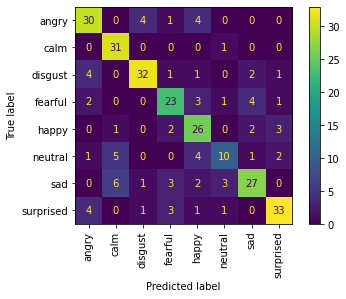

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(xticks_rotation='vertical')

In [71]:
ravdess_df['emotion'].value_counts()

disgust      192
fearful      192
surprised    192
happy        192
angry        192
calm         192
sad          192
neutral       96
Name: emotion, dtype: int64

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.73      0.77      0.75        39
        calm       0.72      0.97      0.83        32
     disgust       0.84      0.78      0.81        41
     fearful       0.70      0.68      0.69        34
       happy       0.63      0.76      0.69        34
     neutral       0.62      0.43      0.51        23
         sad       0.75      0.64      0.69        42
   surprised       0.82      0.77      0.80        43

    accuracy                           0.74       288
   macro avg       0.73      0.73      0.72       288
weighted avg       0.74      0.74      0.73       288



Et. al Khalaf [ref](https://www.researchgate.net/figure/Comparison-of-state-of-the-art-and-proposed-models-using-RAVDESS-database-eight_tbl1_349448074) in August 2020 calimed that the state of the art models in audio emotion recognition task on RAVDESS received 79.5%